In [1]:
import pandas as pd
import numpy as np
import os
import os.path as op
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import binarize
import scipy.stats as st
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#stuff for multiprocessing
from multiprocessing import Pool
from functools import partial
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd") # weird warning

#### Set directory to save simulated data & results

In [2]:
wd = op.join(os.getcwd(), 'simulation_data_FMM')
if not os.path.exists(wd):
    os.makedirs(wd)

### Function to create 2-dimensional dataset

In [3]:
def simulate_data(n_obs=10, n_ind=400, confound_strength=1, seed=None):
    
    if seed:
        np.random.seed(seed)
        
    # The number of independent variables; corresponds to the resolution (number of "pixels") of the img
    cut = np.sqrt(n_ind)
    if not cut == np.round(cut):
        from warnings import warn
        n_ind_old = n_ind
        n_ind = np.round(cut)**2
        warn('The provided n_ind (%d) was not valid. The square root of %d is %.2f... taking the closest valid value: %d' %(n_ind_old, n_ind_old, cut, n_ind))
        cut = np.round(cut)
        
    # Pre-allocate some stuff
    X = np.ndarray((n_obs, int(n_ind)))
    y = np.ndarray(n_obs)
    
    cut = cut * 1j

    # Set up window
    xmin, xmax = -3, 3
    ymin, ymax = -3, 3

    # Set up some stuff for kde
    xx, yy = np.mgrid[xmin:xmax:cut, ymin:ymax:cut]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # Generate weight map
    x_w, y_w = np.random.multivariate_normal((1, .5), [[0.6, 0.1], [0.05, 0.5]], 10000).T
    weights_kernel = st.gaussian_kde(np.vstack([x_w, y_w]))
    weights = np.reshape(weights_kernel(positions), xx.shape)

    # Generate value of confound variable per participant
    confound = np.abs(np.random.normal(1, .2, n_obs))
    
    # Ravel
    weights = weights.ravel()

    for pp in range(n_obs):
        
        # Simulate three sources of signal ("brain areas") using multivariate normal. 
        # The location and spread are defined in the first two arguments; the number of datapoints sampled 
        # (currently set to 1k) influences the noisiness of the sample. More datapoints = less noise.
        x_1, y_1 = np.random.multivariate_normal((1, .5), [[0.6, 0.1], [0.05, 0.5]], 1000).T
        x_2, y_2 = np.random.multivariate_normal((-1, 2), [[0.6, 0.05], [0.05, 0.7]], 1000).T
        x_3, y_3 = np.random.multivariate_normal((-1.5, -2), [[0.7, 0.1], [0.05, 0.5]], 1000).T

        # Set the "weights" of finite mixture model ('signal strength of brain area'). These are modulated by the confound variable: stronger sources of activation are _more_ influenced by brain size than smaller sources of activation.
        pi_ = np.array([.6, .6, .9])*confound[pp]

        # Pre-allocate data matrix
        X_pp = np.full(xx.shape, 0)

        for i, (x, y_) in enumerate([(x_1, y_1), (x_2, y_2), (x_3, y_3)]):
            # Perform kernel density estimation (2 dimensions) to approximate the pdf
            values = np.vstack([x, y_])
            kernel = st.gaussian_kde(values)
            
            # Estimate the density in the positions of the specified grid
            f = np.reshape(kernel(positions), xx.shape)
            
            # Add the density estimates of the current source ("brain area") to the overall dataset, weighted by pi_ ('signal of area')
            X_pp = X_pp + pi_[i]*f

        # Flatten X
        X_pp = X_pp.ravel()

        # Calculate y: value at each location * weight of that location + Gaussian noise
        y_pp = np.dot(X_pp, weights) + np.random.normal(0, .2, 1)

        # Add to output matrices
        X[pp, :] = X_pp
        y[pp] = y_pp
        
    data = {'X':X, 'y':y, 'confound':confound, 'weights':weights, 'orig_shape':xx.shape}
    return data

### Two plotting functions. 

The first, `plot_subject_data()`, plots the data of a few (by default 3) subjects, with spatial dependence of data intact. It shows both the raw data, and the data with the confound removed.

The second, `plot_dataset()`, summarizes data of all participants by flattening each participant to a single row. The spatial information is not clearly visible for us mortal beings. However, it does show correlation matrices before and after removing the confound, which clearly shows removing the confound works.

In [24]:
def plot_subject_data(data, no_conf, sub_n=[0,1,2], coefs=None):
    n_subplots = len(sub_n)+1
    
    X = data['X']
    weights = data['weights']
    shape = data['orig_shape']
    
    #    Set figure, subplots
    fig, axes = plt.subplots(len(sub_n)+1, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    #    Visualize weights
    heatmap1 = axes[0,0].pcolor(weights.reshape(shape), cmap=plt.get_cmap('plasma'), alpha=1)
    axes[0,0].set_xticklabels(np.linspace(-3, 3, len(axes[0,0].get_xticks())))
    axes[0,0].set_yticklabels(np.linspace(-3, 3, len(axes[0,0].get_yticks())))
    axes[0,0].set_title('Weightmap (original, not fitted)')
    
    if coefs.any():
        heatmap2 = axes[0,1].pcolor(coefs.reshape(shape), cmap=plt.get_cmap('plasma'), alpha=1)
        axes[0,1].set_title('Weightmap (fitted coefficients)')
    
    from matplotlib.colors import Normalize
    class MidpointNormalize(Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            # I'm ignoring masked values and all kinds of edge cases to make a
            # simple example...
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))
        
    norm = MidpointNormalize(midpoint=0)
    
    # Visualize X of participants. First, determine the range of colors
    all_dat = np.vstack([data['X'][sub_n,:], no_conf[sub_n, :]])
    vmin = np.min(all_dat)
    vmax = np.max(all_dat)
#     vmin_X = np.min(data['X'][sub_n,:])
#     vmax_X = np.max(data['X'][sub_n,:])
#     vmin_X_nc = np.min(no_conf[sub_n,:])
#     vmax_X_nc = np.max(no_conf[sub_n,:])
#     vmin = np.min([vmin_X, vmin_X_nc])
#     vmax = np.max([vmax_X, vmax_X_nc])
    
#     # Make symmetric surrounding 0
#     if np.abs(vmin) > np.abs(vmax):
#         vmin = -vmax
#     else:
#         vmax = -vmin
        
    for i, sub in enumerate(sub_n):
        heatmap = axes[i+1,0].pcolor(np.reshape(X[sub,:], shape), norm=norm, cmap=plt.get_cmap('bwr'), alpha=0.8, vmin=vmin, vmax=vmax)
        new_xticklabels = np.round(np.linspace(-3, 3, len(axes[i,0].get_xticks())),2)
        new_yticklabels = np.round(np.linspace(-3, 3, len(axes[i,0].get_yticks())),2)
        axes[i+1,0].set_xticklabels(new_xticklabels)
        axes[i+1,0].set_yticklabels(new_yticklabels)
        axes[i+1,0].set_title('Data of participant %d, confound not removed' %sub)
        
        heatmap = axes[i+1,1].pcolor(np.reshape(no_conf[sub,:], shape), norm=norm, cmap=plt.get_cmap('bwr'), alpha=0.8, vmin=vmin, vmax=vmax)
        new_xticklabels = np.round(np.linspace(-3, 3, len(axes[i,1].get_xticks())),2)
        new_yticklabels = np.round(np.linspace(-3, 3, len(axes[i,1].get_yticks())),2)
        axes[i+1,1].set_xticklabels(new_xticklabels)
        axes[i+1,1].set_yticklabels(new_yticklabels)
        axes[i+1,1].set_title('Data of participant %d, confound removed' %sub)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(heatmap, cax=cbar_ax)


In [25]:
def plot_dataset(data, no_conf, coefs, save_dir=None, _id=None):

    # Set-up figure, axes
    f, axes = plt.subplots(2,3)
    f.set_figheight(15)
    f.set_figwidth(15)

    # Plot 1: actual data
    df = pd.DataFrame(data['X'])
    sns.heatmap(df, ax=axes[0,0])
    axes[0,0].set_title('Raw data colorized')

    # Plot 2: correlation matrix of IVs, DV, and confound
    df['confound'] = data['confound']
    df['y'] = data['y']

    sns.heatmap(df.corr(), ax=axes[0,1])
    axes[0,1].set_title('Correlation matrix IVs, confound, DV')

    # Plot 3: Actual weights, colorized. The colors should roughly correspond to the correlation between y and each IV.
    sns.heatmap(pd.DataFrame(data['weights']).transpose(), ax=axes[0,2])
    axes[0,2].set_title('Weights colorized')

    # Plot 4: Data with variance explained by the confound regressed out.
    nc = pd.DataFrame(no_conf)

    sns.heatmap(nc, ax=axes[1,0])
    axes[1,0].set_title('Data after removing confound, colorized')

    # Plot 5: Correlation matrix after regressing out confound
    nc['confound'] = data['confound']
    nc['y'] = data['y']
    sns.heatmap(nc.corr(), ax=axes[1,1])
    axes[1,1].set_title('Correlation matrix NC IVs, confound, DV')

    # Plot 6: fitted estimates of weights. NOTE: DOES NOT NECESSARILY MAKE SENSE FOR LOGISTIC REG!
    sns.heatmap(pd.DataFrame(coefs).transpose(), ax=axes[1,2])
    axes[1,2].set_title('Fitted coefficients')


### Function to regress out ('partial out') the variance in X that can be explained by the confounding variable

In [26]:
def regress_out_confound(X, conf):
    '''
    Regresses out confounds from a matrix of independent vars
    '''
        
    for x_i in np.arange(X.shape[1]):
        mod = LinearRegression().fit(X=conf.reshape(-1,1), y=X[:,x_i].reshape(-1,1))
        
        preds = mod.predict(conf.reshape(-1,1))
        preds = preds.reshape((preds.shape[0],))
        X[:,x_i] = X[:,x_i] - preds
        
    return X

### Class to perform K-fold cross-validated classification

In [27]:
class Clf(object):
    '''
    K-fold cross-validation routine: learns weights on train data, predicts & scores test data. 
    Returns a vector of n_folds accuracies. Defaults to 10 folds.
    '''
    
    def __init__(self, X, y, n_splits=10):
        self.X = X
        self.y = y
        self.folds = KFold(n_splits=n_splits)
        self.acc = np.ndarray(n_splits)
        self.weights = np.ndarray((n_splits, X.shape[1]))

    def train_fit(self):
        X = self.X
        y = self.y
        for i, (train_idx, test_idx) in enumerate(self.folds.split(X)):
            X_train = X[train_idx,:]
            y_train = y[train_idx]
            X_test = X[test_idx,:]
            y_test = y[test_idx]

            mod = LogisticRegression().fit(X=X_train, y=y_train)
            self.acc[i] = mod.score(X=X_test, y=y_test)   
            self.weights[i,:] = mod.coef_
        
        return self

### Useful process function
(not used in the example below but useful for multiprocessed grid search...)

In [28]:
def process(dataset_n, n_obs, n_ind, regress_confound=True, plot=True, verbose=False, save_dir=None):
    
    # Generate data
    data = simulate_data(n_obs, n_ind, dataset_n)
    
    if regress_confound:
        # Regress out brain size from X
        data_orig = deepcopy(data)
        data['X'] = regress_out_confound(X=data['X'], conf=data['confound'])
    
    # Binarize y
    y2 = binarize(data['y'], threshold=np.median(data['y']))
    y2 = np.ravel(y2)
    
    # Perform K-fold crossvalidation
    clf = Clf(X=data['X'], y=y2, n_splits=10)
    clf.train_fit()
    mean_acc = np.mean(clf.acc)
    coefs = np.mean(clf.weights, axis=0)
    
#     print(coefs)
    
    if plot:
        plot_subject_data(data_orig, no_conf=data['X'], sub_n=[0,1,2])
        plot_dataset(data_orig, no_conf=data['X'], coefs=coefs, save_dir=save_dir, _id=dataset_n)
    
    if verbose:
#        print('Settings: n_ind = %d, corr_independent_confound = %.2f, corr_indep_dependent = %.2f, dataset %d, accuracy: %.3f' %(n_ind, corr_independent_confound, corr_indep_dependent, dataset_n, mean_acc))
        print('Settings: n_ind = %d, dataset: %d, accuracy: %.3f' %(n_ind, dataset_n, mean_acc))

    return mean_acc

## Example

/Users/steven/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Mean accuracy of 10-fold cross-val classification (confound not removed): 0.77
Mean accuracy of 10-fold cross-val classification (confound removed): 0.35


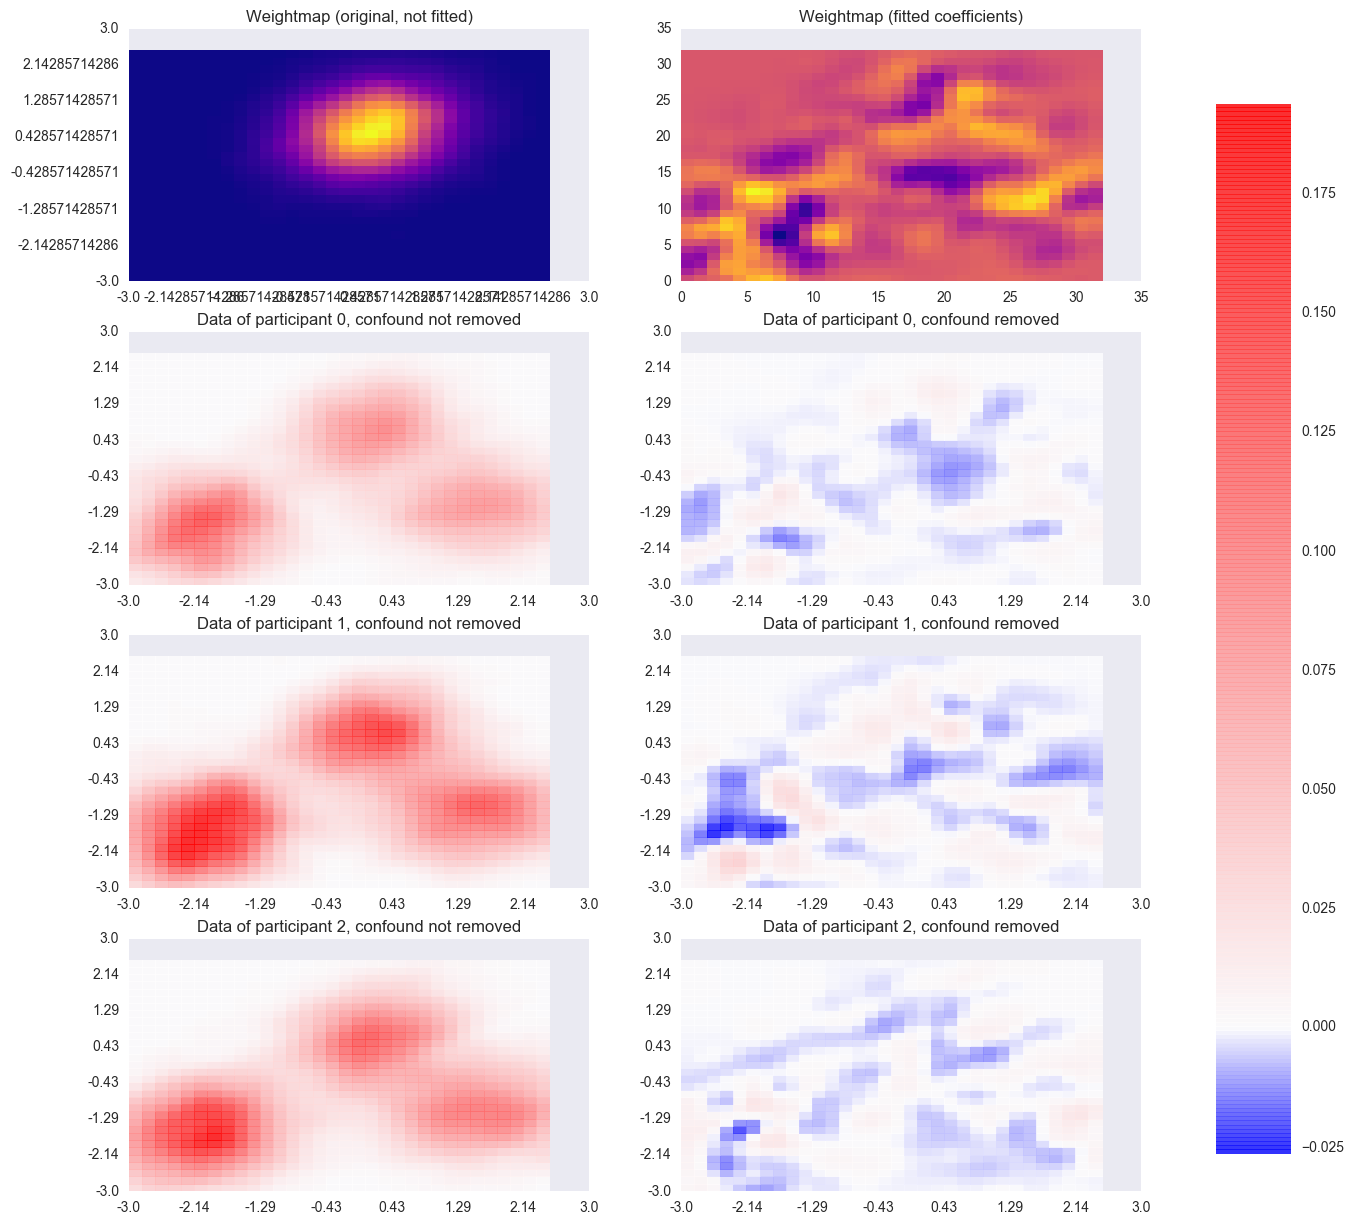

In [30]:
# Generate data
data = simulate_data(n_obs=100, n_ind=1024, seed=1)

regress_confound = True
if regress_confound:
    # Regress out brain size from X
    data_orig = deepcopy(data)
    data['X'] = regress_out_confound(X=data['X'], conf=data['confound'])

# Binarize y
y2 = binarize(data['y'], threshold=np.median(data['y']))
y2 = np.ravel(y2)

# Perform K-fold crossvalidation
clf = Clf(X=data_orig['X'], y=y2, n_splits=10)
clf.train_fit()
mean_acc = np.mean(clf.acc)
coefs = np.mean(clf.weights, axis=0)
print('Mean accuracy of 10-fold cross-val classification (confound not removed): %.2f' %mean_acc)


clf = Clf(X=data['X'], y=y2, n_splits=10)
clf.train_fit()
mean_acc = np.mean(clf.acc)
coefs = np.mean(clf.weights, axis=0)
print('Mean accuracy of 10-fold cross-val classification (confound removed): %.2f' %mean_acc)

plot_subject_data(data_orig, no_conf=data['X'], sub_n=[0,1,2], coefs=coefs)

2 interesting things to notice:
1. The _sign_ of the data changes from positive to negative when the confound is partialled out
2. The fitted weight map in no way resembles the actual weight map (!!); rather, it seems to resemble the structure of the data itself... (nb: the weight maps are not on the same color scale yet!)

Still don't know what exactly is going on here but this is quite interesting.. should get the weight maps on the same color scale for a fair comparison

In [14]:
#plot_dataset(data_orig, no_conf=data['X'], coefs=coefs)
# this takes a bit long